In [2]:
import pandas as pd
import numpy as np
from libsvm.svmutil import *
from libsvm.commonutil import *
import random
from scipy import sparse
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

In [4]:
header_list = ["Sex", "Length", "Diameter", "Height", "Whole weight", 
               "Shucked weight", "Viscera weight", "Shell weight", "Rings"]
df = pd.read_csv("abalone.data", names=header_list)

In [5]:
df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


In [6]:
df["Sex"].value_counts()

M    1528
I    1342
F    1307
Name: Sex, dtype: int64

In [7]:
df["Sex"].replace(['M', 'I', 'F'], [1, 3, 2], inplace=True)

In [8]:
df = pd.concat([pd.get_dummies(df['Sex']), df], axis=1)

In [9]:
df = df.drop(columns=['Sex'])

In [10]:
df.head()

,1,2,3,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,1,0,0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,1,0,0,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0,1,0,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,1,0,0,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0,0,1,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [11]:
df['Rings'] = (df['Rings'] >= 9).astype(int)

In [12]:
df["Rings"].value_counts()

1    2770
0    1407
Name: Rings, dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   1               4177 non-null   uint8  
 1   2               4177 non-null   uint8  
 2   3               4177 non-null   uint8  
 3   Length          4177 non-null   float64
 4   Diameter        4177 non-null   float64
 5   Height          4177 non-null   float64
 6   Whole weight    4177 non-null   float64
 7   Shucked weight  4177 non-null   float64
 8   Viscera weight  4177 non-null   float64
 9   Shell weight    4177 non-null   float64
 10  Rings           4177 non-null   int32  
dtypes: float64(7), int32(1), uint8(3)
memory usage: 257.1 KB


In [14]:
df.to_csv("test.txt", header=False)

In [15]:
def csr_scale(x, scale_param):
    assert isinstance(x, sparse.csr_matrix)

    offset = scale_param['offset']
    coef = scale_param['coef']
    assert len(coef) == len(offset)

    l, n = x.shape

    if not n == len(coef):
        print("WARNING: The dimension of scaling parameters and feature number do not match.", file=sys.stderr)
        coef = resize(coef, n)
        offset = resize(offset, n)

    # scaled_x = x * diag(coef) + ones(l, 1) * offset'
    offset = sparse.csr_matrix(offset.reshape(1, n))
    offset = sparse.vstack([offset] * l, format='csr', dtype=x.dtype)
    scaled_x = x.dot(sparse.diags(coef, 0, shape=(n, n))) + offset

    if scaled_x.getnnz() > x.getnnz():
        print(
            "WARNING: original #nonzeros %d\n" % x.getnnz() +
            "       > new      #nonzeros %d\n" % scaled_x.getnnz() +
            "If feature values are non-negative and sparse, get scale_param by setting lower=0 rather than the default lower=-1.",
            file=sys.stderr)

    return scaled_x

In [16]:
X_train = np.array(df.iloc[:, :10])[:3133]
X_test = np.array(df.iloc[:, :10])[3133:]
y_train = np.array(df.iloc[:, 10])[:3133]
y_test = np.array(df.iloc[:, 10])[3133:]

In [17]:
X_train_sci = sparse.csr_matrix(X_train)
X_test_sci = sparse.csr_matrix(X_test)
y_train_sci = sparse.csr_matrix(y_train)
y_test_sci = sparse.csr_matrix(y_test)

In [ ]:
# scaling
scale_param = csr_find_scale_param(X_train_sci, lower=0)
scaled_X_train = csr_scale(X_train_sci, scale_param)
scale_param = csr_find_scale_param(X_test_sci, lower=0)
scaled_X_test = csr_scale(X_test_sci, scale_param)

In [19]:
def param(s=0, t=1, d=1, v=5, c=2):
    return f'-s {s} -t {t} -d {d} -v {v} -c {c}'

# Q3

Cross Validation Accuracy = 78.3275%
Cross Validation Accuracy = 78.3275%
Cross Validation Accuracy = 78.3275%
Cross Validation Accuracy = 79.2212%
Cross Validation Accuracy = 81.9342%
Cross Validation Accuracy = 83.3067%
Cross Validation Accuracy = 83.3387%
Cross Validation Accuracy = 83.5302%
Cross Validation Accuracy = 83.4663%
Cross Validation Accuracy = 83.6259%
Cross Validation Accuracy = 83.6578%

d=1:


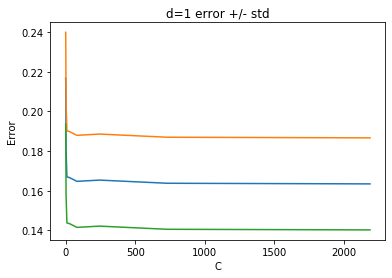

Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 78.3913%
Cross Validation Accuracy = 78.4871%
Cross Validation Accuracy = 78.4552%
Cross Validation Accuracy = 80.9448%
Cross Validation Accuracy = 82.7003%
Cross Validation Accuracy = 83.3067%
Cross Validation Accuracy = 83.1791%
Cross Validation Accuracy = 83.1152%
Cross Validation Accuracy = 82.828%
Cross Validation Accuracy = 83.0833%

d=2:


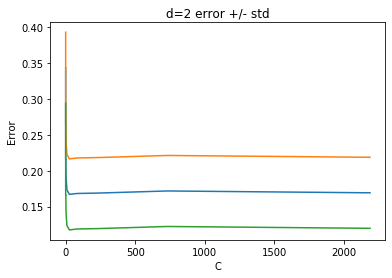

Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 79.0935%
Cross Validation Accuracy = 79.5723%
Cross Validation Accuracy = 80.849%
Cross Validation Accuracy = 81.9342%
Cross Validation Accuracy = 82.4769%
Cross Validation Accuracy = 83.0195%
Cross Validation Accuracy = 83.0514%
Cross Validation Accuracy = 83.0833%

d=3:


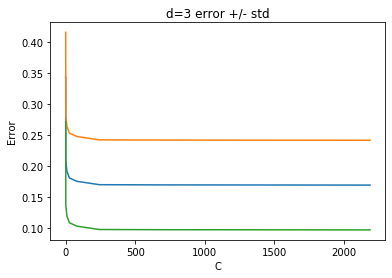

Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 79.4446%
Cross Validation Accuracy = 79.285%
Cross Validation Accuracy = 80.9767%
Cross Validation Accuracy = 82.0619%
Cross Validation Accuracy = 82.1577%
Cross Validation Accuracy = 82.7641%
Cross Validation Accuracy = 83.2429%

d=4:


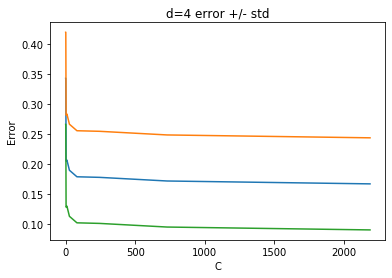

Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 65.6559%
Cross Validation Accuracy = 77.6891%
Cross Validation Accuracy = 80.3383%
Cross Validation Accuracy = 82.4769%
Cross Validation Accuracy = 82.7322%
Cross Validation Accuracy = 82.6045%

d=5:


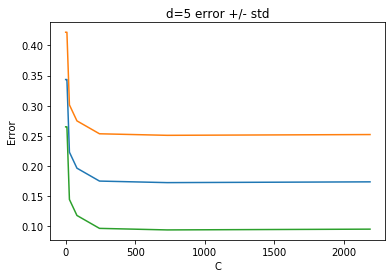

In [21]:
# Q3
d_lst = [1,2,3,4,5]
c_lst = []
for i in range(-3, 8):
    c_lst.append(pow(3, i))
# train
for d in d_lst:
    err_lst = []
    for c in c_lst:
        svm=svm_train(y_train.tolist(), scaled_X_train.toarray().tolist(), param(c=c, d=d)) * 0.01
        err_lst.append(1-svm)
    # plot
    print(f'\nd={d}:')
    std = np.std(err_lst)
    std_p = err_lst + std
    std_m = err_lst - std
    plt.plot(c_lst, err_lst)
    plt.plot(c_lst, std_p)
    plt.plot(c_lst, std_m)
    plt.xlabel("C")
    plt.ylabel("Error")
    plt.title(f"d={d} error +/- std")
    plt.show()

In [20]:
def param_2(s=0, t=1, d=1, c=2):
    return f'-s {s} -t {t} -d {d} -c {c}'

# Q4

Cross Validation Accuracy = 83.7855%
Accuracy = 77.5862% (810/1044) (classification)
Cross Validation Accuracy = 83.0514%
Accuracy = 79.5019% (830/1044) (classification)
Cross Validation Accuracy = 83.1152%
Accuracy = 82.6628% (863/1044) (classification)
Cross Validation Accuracy = 82.3492%
Accuracy = 83.046% (867/1044) (classification)
Cross Validation Accuracy = 82.4769%
Accuracy = 84.4828% (882/1044) (classification)
[1, 2, 3, 4, 5]
[0.16214490903287582, 0.16948611554420678, 0.1688477497606128, 0.17650813916374086, 0.17523140759655287]


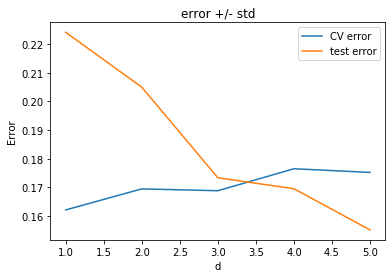

In [23]:
# Q4
# best pair: d=1, c=3^5
d_lst = [1,2,3,4,5]
c = pow(3,5)
cv_err_lst = []
test_err_lst = []
for d in d_lst:
    svm=svm_train(y_train.tolist(), scaled_X_train.toarray().tolist(), param(c=c, d=d)) * 0.01
    cv_err_lst.append(1-svm)
    svm = svm_train(y_train.tolist(), scaled_X_train.toarray().tolist(), param_2(c=c, d=d))
    test_err = svm_predict(y_test.tolist(), scaled_X_test.toarray().tolist(), svm)[1][0] * 0.01
    test_err_lst.append(1 - test_err)
# plot
print(d_lst)
print(cv_err_lst)
plt.plot(d_lst, cv_err_lst, label="CV error")
plt.plot(d_lst, test_err_lst, label="test error")
plt.xlabel("d")
plt.ylabel("Error")
plt.title("error +/- std")
plt.legend()
plt.show()

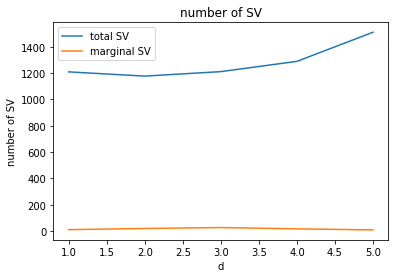

In [24]:
# it seems like libsvm only output SV information on terminal, so I collected the results for running the code above and plot
# the marginal SV and total SV
SV = [1209, 1177, 1211, 1289, 1510]
BSV = [1198, 1157, 1184, 1272, 1501]
MSV = [a - b for a, b in zip(SV, BSV)]
# plot
plt.plot(d_lst, SV, label="total SV")
plt.plot(d_lst, MSV, label="marginal SV")
plt.xlabel("d")
plt.ylabel("number of SV")
plt.title("number of SV")
plt.legend()
plt.show()

# Q5

Cross Validation Accuracy = 89.7764%
Accuracy = 74.9042% (782/1044) (classification)
Cross Validation Accuracy = 83.9457%
Accuracy = 73.4674% (767/1044) (classification)
Cross Validation Accuracy = 82.9073%
Accuracy = 72.8927% (761/1044) (classification)
Cross Validation Accuracy = 84.1853%
Accuracy = 82.2797% (859/1044) (classification)
Cross Validation Accuracy = 83.6102%
Accuracy = 77.7778% (812/1044) (classification)


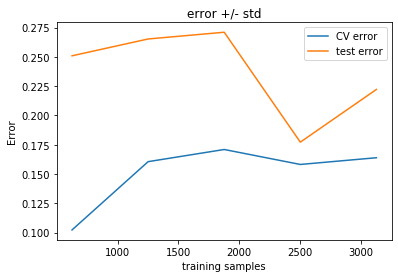

In [25]:
# Q5
cv_err_lst = []
test_err_lst = []
train_samples = []
train_split = y_train.shape[0] // 5
train_split_idx = train_split
d=1
c=pow(3, 6)

for _ in range(5):
    if train_split_idx >= y_train.shape[0]:
        train_split_idx = y_train.shape[0]
    train_samples.append(train_split_idx)
    svm = svm_train(y_train[:train_split_idx].tolist(), scaled_X_train.toarray()[:train_split_idx].tolist(), param(c=c, d=d)) * 0.01
    cv_err_lst.append(1-svm)
    svm = svm_train(y_train[:train_split_idx].tolist(), scaled_X_train.toarray()[:train_split_idx].tolist(), param_2(c=c, d=d))
    test_err = svm_predict(y_test.tolist(), scaled_X_test.toarray().tolist(), svm)[1][0] * 0.01
    test_err_lst.append(1 - test_err)
    train_split_idx += train_split
# plot
# print(d_lst)
# print(cv_err_lst)
plt.plot(train_samples, cv_err_lst, label="CV error")
plt.plot(train_samples, test_err_lst, label="test error")
plt.xlabel("training samples")
plt.ylabel("Error")
plt.title("error +/- std")
plt.legend()
plt.show()

# Q6

In [447]:
# Q6
from copy import deepcopy

class SVM(object):
    def __init__(self, C, kernel='poly', p = 2, max_iter = 100, learning_rate = 1e-3):
        self.X_train = np.array([])
        self.y_train = np.array([])
        self.alpha = np.array([])
        self.b = 0
        self.C = (float)(C)
        self.p = p
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        if kernel == 'poly':
            self.kernel_name = kernel
            self.kernel = self.polynomial_kernel
    
    # polynomial kernel computation
    def polynomial_kernel(self, X, Y, p=2):
        return (np.inner(X, Y)) ** p
    
    # compute kernel function with given kernel name
    def compute_kernel(self, X, Y, kernel):
        X_rows, X_cols = X.shape
        Y_rows, Y_cols = Y.shape
        K = np.zeros((X_rows, Y_rows))
        K = kernel(X, Y, self.p)
        return K
    
    def compute_objective(self, X, y):
        constrain = y * np.sum(self.alpha * y * (self.compute_kernel(X, X, self.kernel)) + self.b, axis=0).reshape(-1, 1)
        # print(constrain.shape)
        # constrain = y * np.sum(self.W * y * self.compute_kernel(X, X, self.kernel) + self.b)
        grad_map = (constrain < 1).astype(int)
        return 1/2 * np.sum(np.absolute(self.alpha)) + self.C * np.sum((1 - constrain) * grad_map)
    
    def fit(self, X, y):
        X_rows, X_cols = X.shape
        # reshape
        y = y.reshape((X_rows, 1))
        
        self.X_train = X
        self.y_train = deepcopy(y)
        self.y_train[self.y_train == 0] = -1
        #print(self.y_train)
        
        #self.W = np.random.rand(X_rows, 1)
        self.alpha = np.zeros((X_rows, 1))
        iter_count = 0
        prev_objective = 10000
        
        while iter_count < self.max_iter:
            constrain = y * np.sum(self.alpha * y * (self.compute_kernel(X, X, self.kernel)) + self.b, axis=0).reshape(-1, 1)
            # print(f"(self.compute_kernel(X, X, self.kernel)): {y * np.sum(y * (self.compute_kernel(X, X, self.kernel)) + self.b, axis=0)}")
            # calculate gradients
            grad_map = (constrain < 1).astype(int)
            #print(f"grad_map: {grad_map}")
            unique, counts = np.unique(grad_map, return_counts=True)
            #print(np.asarray((unique, counts)).T)
            #print(f"iter: {iter_count}")
            #print(f"objective value: {prev_objective}")
            grad_alpha_constrain = y * np.sum(y * (self.compute_kernel(X, X, self.kernel)) + self.b, axis=0).reshape(-1, 1)
            grad_alpha = 1/2 - (self.C * grad_alpha_constrain * grad_map)
            #print(f"alpha: {self.alpha}")
            grad_b = self.C * np.sum(-y * grad_map)
            #print(f"b: {self.b}\n")
            # update gradients
            self.alpha -= self.learning_rate * grad_alpha
            self.b -= self.learning_rate * grad_b
            # get current objective
            cur_objective = self.compute_objective(X, y)
            iter_count += 1;
            if cur_objective > prev_objective:
                #print(f"prev_objective: {prev_objective}")
                #print(f"cur_objective: {cur_objective}")
                break
            else:
                prev_objective = cur_objective
            
    def predict_proba(self, X):
        K = self.compute_kernel(X_train, X, self.kernel)
        y_pred = np.sum(self.alpha * self.y_train * self.kernel(self.X_train, X, p=self.p) + self.b, axis=0).reshape(-1, 1)
        return y_pred
    
    def predict(self, X):
        # compute kernel output for X and Support Vectors
        #print(self.predict_proba(X))
        res = (self.predict_proba(X) > 1).astype(int)
        res = np.where(res == 1, 1, 0)
        return res

In [450]:
# search for best C
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from statistics import mean

d_lst = [1,2,3,4,5]
c_lst = [3e-3, 2e-3, 1e-3, 2e-2, 1e-2, 2e-1, 1e-1, 1, 10, 20, 50]
# c_lst = []
# for i in range(-3, 8):
#     c_lst.append(pow(3, i))
kf = StratifiedKFold(n_splits=5, shuffle=True)

for d in d_lst:
    print()
    for c in c_lst:
        svm = SVM(C = c, kernel='poly', p = d, max_iter = 100, learning_rate = 1e-6)
        train_error_lst = []
        test_error_lst = []
        X = scaled_X_train.toarray()
        for train_index, test_index in kf.split(X, y_train):
            X_train, X_test = X[train_index], X[test_index]
            #X_train, X_test = X, scaled_X_test.toarray()
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
            #y_train_cv, y_test_cv = y_train, y_test
            svm.fit(X_train, y_train_cv)
            y_pred_test = svm.predict(X_test).flatten()
            y_pred_train = svm.predict(X_train).flatten()
            test_error = 1 - accuracy_score(y_pred_test, y_test_cv)
            train_error = 1 - accuracy_score(y_pred_train, y_train_cv)
            train_error_lst.append(train_error)
            test_error_lst.append(test_error)
        print(f"d: {d}, c: {c}, train_error: {mean(train_error_lst)}, test_error: {mean(test_error_lst)}")


d: 1, c: 0.003, train_error: 0.29475788621866755, test_error: 0.2895307539834192
d: 1, c: 0.002, train_error: 0.2784782974789504, test_error: 0.28059627721642183
d: 1, c: 0.001, train_error: 0.24185882084035412, test_error: 0.24513556618819776
d: 1, c: 0.02, train_error: 0.3238079108742926, test_error: 0.32494000030573095
d: 1, c: 0.01, train_error: 0.3163857241224969, test_error: 0.3153706223153003
d: 1, c: 0.2, train_error: 0.34336098349999095, test_error: 0.3434407977538968
d: 1, c: 0.1, train_error: 0.33474166985274434, test_error: 0.33450937829616156
d: 1, c: 1, train_error: 0.3434407919596877, test_error: 0.3434407977538968
d: 1, c: 10, train_error: 0.3434407919596877, test_error: 0.3434407977538968
d: 1, c: 20, train_error: 0.3434407919596877, test_error: 0.3434407977538968
d: 1, c: 50, train_error: 0.3434407919596877, test_error: 0.3434407977538968

d: 2, c: 0.003, train_error: 0.21057925279289816, test_error: 0.21322286255866213
d: 2, c: 0.002, train_error: 0.1930241612391926

In [461]:
# plot five-fold cross-validation errors
# best C = 0.001
c = 0.001
d_lst = [1,2,3,4,5]

kf = StratifiedKFold(n_splits=5, shuffle=True)
mean_train_error_lst = []
mean_test_error_lst = []
for d in d_lst:
    train_error_lst = []
    test_error_lst = []
    svm = SVM(C = c, kernel='poly', p = d, max_iter = 100, learning_rate = 1e-6)
    X = scaled_X_train.toarray()
    for train_index, test_index in kf.split(X, y_train):
        X_train, X_test = X[train_index], X[test_index]
        #X_train, X_test = X, scaled_X_test.toarray()
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        #y_train_cv, y_test_cv = y_train, y_test
        svm.fit(X_train, y_train_cv)
        y_pred_test = svm.predict(X_test).flatten()
        y_pred_train = svm.predict(X_train).flatten()
        test_error = 1 - accuracy_score(y_pred_test, y_test_cv)
        train_error = 1 - accuracy_score(y_pred_train, y_train_cv)
        train_error_lst.append(train_error)
        test_error_lst.append(test_error)
    mean_train_error_lst.append(mean(train_error_lst))
    mean_test_error_lst.append(mean(test_error_lst))
    print(f"d: {d}, c: {c}, train_error: {mean(train_error_lst)}, test_error: {mean(test_error_lst)}")
    print()

d: 1, c: 0.001, train_error: 0.24569019992226077, test_error: 0.2400262928596542

d: 2, c: 0.001, train_error: 0.20148640470688456, test_error: 0.20299055800989546

d: 3, c: 0.001, train_error: 0.1958187625327455, test_error: 0.1962981080351183

d: 4, c: 0.001, train_error: 0.19605828341457965, test_error: 0.19597963832031426

d: 5, c: 0.001, train_error: 0.17084278943141168, test_error: 0.1717244752892979



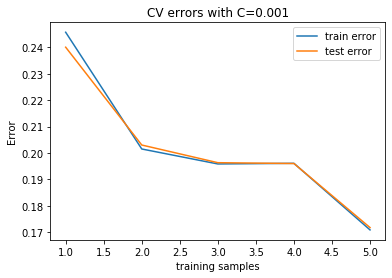

In [463]:
plt.plot(d_lst, mean_train_error_lst, label="train error")
plt.plot(d_lst, mean_test_error_lst, label="test error")
plt.xlabel("training samples")
plt.ylabel("Error")
plt.title("CV errors with C=0.001")
plt.legend()
plt.show()